In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
from scipy.stats import linregress
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import oh_to_12pluslog, mu, get_velocity_profile, boxcarsmoothtrend
from src.simulations.models.insideout import insideout
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=0, releaselevel='final', serial=0)


In [2]:
def equilibrium_profile(output, lookback, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * i for i in range(len(output.zones.keys()))]
        mu_g = mu_o = len(radii) * [0.]
    radii = [r + zone_width / 2 for r in radii]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zeq = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            taustar = float("inf")
            eta = 0
        recycling = zone.history["r_eff"][idx]
        sfh = insideout(radii[i])
        tausfh = sfh.timescale
        zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling - taustar / tausfh))
    return [radii, zeq]

def eq_gradient(output, lookback, zone_width = 0.1):
    radii, zeq = equilibrium_profile(output, lookback, zone_width = 0.1)
    start = None
    stop = None
    i = 0
    while start is None or stop is None:
        if radii[i] >= 5 and start is None: start = i
        if radii[i] >= 10 and stop is None: stop = i
        i += 1
    oheq = [np.log10(z / vice.solar_z['o']) for z in zeq[start:stop]]
    eqprof = linregress(radii[start:stop], oheq)
    return eqprof.slope

def ism_gradient(output, lookback, zone_width = 0.1):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = []
    start = None
    stop = None
    i = 0
    while start is None or stop is None:
        if radii[i] >= 5 and start is None: start = i
        if radii[i] > 10 and stop is None: stop = i
        i += 1
    for i in range(start, stop):
        zone = output.zones["zone%d" % (i)]
        oh.append(zone.history["[o/h]"][idx])
    # print(list(zip(radii[start:stop], oh)))
    ohprof = linregress(radii[start:stop], oh)
    return ohprof.slope

In [4]:
# River model ISM and equilibrium gradients (respectively): -0.1368 -0.1656
outputs = [
    "../outputs/constant/vgas-0p5",
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1p5",
    "../outputs/potential_well_deepening/gamma0p1",
    "../outputs/potential_well_deepening/gamma0p2",
    "../outputs/potential_well_deepening/gamma0p3",
    "../outputs/amd/betaphiin0p8",
    "../outputs/amd/betaphiin0p7",
    "../outputs/amd/betaphiin0p6",
    "../outputs/constant/vgas-0"
    # "../outputs/river/insideout"
]
outputs = [vice.output(name) for name in outputs]

../outputs/constant/vgas-0p5 -0.0520 -0.0461
../outputs/constant/vgas-1 -0.0627 -0.0639
../outputs/constant/vgas-1p5 -0.0694 -0.0712


/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  mu *= -tau_star * vgas[i]


../outputs/potential_well_deepening/gamma0p1 -0.0495 -0.0299
../outputs/potential_well_deepening/gamma0p2 -0.0579 -0.0427
../outputs/potential_well_deepening/gamma0p3 -0.0654 -0.0557
../outputs/amd/betaphiin0p8 -0.0611 -0.0559
../outputs/amd/betaphiin0p7 -0.0717 -0.0764
../outputs/amd/betaphiin0p6 -0.0807 -0.0912
../outputs/constant/vgas-0 -0.0384 -0.0172


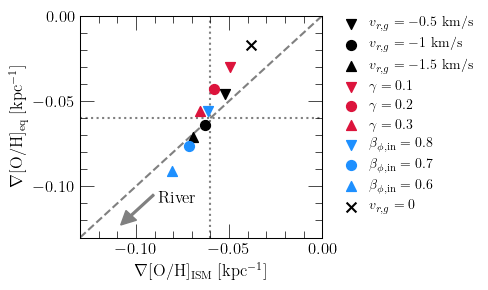

In [7]:
COLORS = [
    "black", "black", "black",
    "crimson", "crimson", "crimson",
    "dodgerblue", "dodgerblue", "dodgerblue",
    "black"
    # "lime"
]
MARKERS = [
    "triangle_down", "circle", "triangle_up",
    "triangle_down", "circle", "triangle_up",
    "triangle_down", "circle", "triangle_up",
    "x"
    # "thin_diamond"
]
LABELS = [
    r"$v_{r,g} = -0.5$ km/s", r"$v_{r,g} = -1$ km/s", r"$v_{r,g} = -1.5$ km/s",
    r"$\gamma = 0.1$", r"$\gamma = 0.2$", r"$\gamma = 0.3$",
    r"$\beta_{\phi,\text{in}} = 0.8$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$\beta_{\phi,\text{in}} = 0.6$",
    # "River"
    r"$v_{r,g} = 0$"
]

fig = plt.figure(figsize = (5, 3.))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$\nabla$[O/H]$_\text{ISM}$ [kpc$^{-1}$]")
ax.set_ylabel(r"$\nabla$[O/H]$_\text{eq}$ [kpc$^{-1}$]")
# ax.set_xlim([-0.2, 0])
ax.set_xlim([-0.13, 0])
ax.set_ylim(ax.get_xlim())
# ax.set_xticks([-0.2, -0.15, -0.1, -0.05, 0])
# ax.set_yticks([-0.2, -0.15, -0.1, -0.05, 0])
ax.set_xticks([-0.1, -0.05, 0])
ax.set_yticks([-0.1, -0.05, 0])

mwslope = -0.06
kwargs = {
    "c": named_colors()["grey"],
    "linestyle": "--",
    "zorder": -1000
}
ax.plot(ax.get_xlim(), ax.get_xlim(), **kwargs)
kwargs["linestyle"] = ":"
ax.axvline(mwslope, **kwargs)
ax.axhline(mwslope, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "marker": markers()[MARKERS[i]],
        "label": LABELS[i],
        "s": 50
    }
    if i: kwargs["zorder"] = 0
    ism = ism_gradient(outputs[i], 0)
    eq = eq_gradient(outputs[i], 0)
    # print(ism, eq)
    print(outputs[i].name, "%.4f" % (ism), "%.4f" % (eq))
    ax.scatter(ism, eq, **kwargs)

# shaded = [-0.07, -0.05]
# ax.plot(shaded, shaded, c = named_colors()["black"], zorder = -100)
# ax.scatter([-0.06], [-0.06],
#     c = named_colors()["grey"],
#     marker = markers()["x"],
#     s = 50,
#     zorder = -1000,
#     label = "MW")
# ax.text(-0.15, -0.065, r"MW", fontsize = 12)
# ax.arrow(-0.12, -0.06, 0.03, 0,
#     color = named_colors()["grey"],
#     head_length = 0.01,
#     head_width = 0.01)

ax.text(-0.088, -0.11, r"River", fontsize = 12)
ax.arrow(-0.0905, -0.105, -0.012, -0.012,
    color = named_colors()["grey"],
    head_length = 0.008,
    head_width = 0.008)

kwargs = {
    "loc": mpl_loc("center left"),
    "bbox_to_anchor": (1.01, 0.55),
    "fontsize": 10,
    "scatterpoints": 1
}
leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/gradism-gradeq-comp.%s" % (ext), **kwargs)
plt.show()

In [16]:
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/constant/vgas-0p5",
    "../outputs/potential_well_deepening/gamma0p2",
    "../outputs/amd/betaphiin0p7",
    "../outputs/river/insideout"
]
# outputs = [
#     "../outputs/river/insideout",
#     "../outputs/potential_well_deepening/gamma0p2",
#     "../outputs/amd/betaphiin0p7",
#     "../outputs/constant/vgas-0",
#     "../outputs/constant/vgas-0p5"
# ]
outputs = [vice.output(name) for name in outputs]

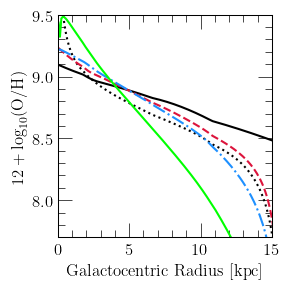

In [17]:
# COLORS = ["black", "black", "crimson", "crimson", "crimson", "dodgerblue", "dodgerblue", "dodgerblue", "lime"]
COLORS = ["black", "black", "crimson", "dodgerblue", "lime"]
# COLORS = ["lime", "crimson", "dodgerblue", "black", "black"]
LINESTYLES = [
    "-", # v = -0.5 km/s
    ":", # v = 0
    "--", # PWD
    "-.", # AMD
    "-", # River
]
LABELS = [
    r"$v_{r,g} = -0.5$ km/s",
    r"$v_{r,g} = 0$",
    r"$\gamma = 0.2$",
    r"$\beta_{\phi,\text{in}} = 0.7$",
    "River",
]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$12 + \log_{10}(\text{O/H})$")
ax.set_xlim([0, 15])
ax.set_ylim([7.7, 9.5])

def plot_profile(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    oh = [output.zones["zone%d" % (i)].history["[o/h]"][idx] for i in range(len(radii))]
    oh = [oh_to_12pluslog(_) for _ in oh]
    ax.plot(radii, oh, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_profile(outputs[i], 0, **kwargs)

# kwargs = {
#     "loc": mpl_loc("lower left"),
#     "handlelength": 1.5,
#     "fontsize": 10
# }
# leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/scenarios-profile-comp.%s" % (ext), **kwargs)
plt.show()

/var/folders/mh/jf6nfbl941l_41vvvwwk5wbr0000gn/T/ipykernel_72870/803564687.py:47: RuntimeWarning: invalid value encountered in log10
  logratio = [np.log10(r) for r in ratio]


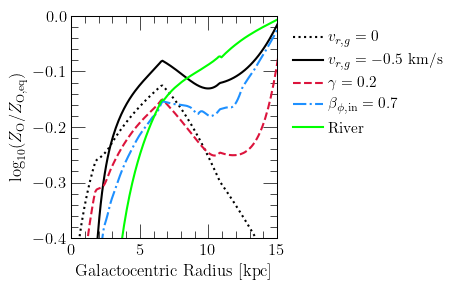

In [49]:
# COLORS = ["black", "black", "crimson", "crimson", "crimson", "dodgerblue", "dodgerblue", "dodgerblue", "lime"]
# COLORS = ["lime", "crimson", "dodgerblue", "black", "black"]
COLORS = ["black", "black", "crimson", "dodgerblue", "lime"]
LINESTYLES = [
    ":", # v = 0
    "-", # v = -0.5 km/s
    "--", # PWD
    "-.", # AMD
    "-", # River
]
LABELS = [
    r"$v_{r,g} = 0$",
    r"$v_{r,g} = -0.5$ km/s",
    r"$\gamma = 0.2$",
    r"$\beta_{\phi,\text{in}} = 0.7$",
    "River"
]

fig = plt.figure(figsize = (4.7, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\log_{10}(Z_\text{O} / Z_\text{O,eq})$")
ax.set_xlim([0, 15])
ax.set_ylim([-0.4, 0])
# ax.set_yscale("log")
# ax.set_ylim([0.03, 1])
# ax.set_ylim([0, 1])
# ax.set_yticks([0, 0.5, 1])
# ax.axhline(1, c = named_colors()["black"], linestyle = ":")

# norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
# cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
# cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
# # cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
# cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
# cbar.set_label("Lookback Time [Gyr]", labelpad = 10)
# cbar.set_ticks(LOOKBACKS)

def plot_eqratioprofile(ax, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, zeq = equilibrium_profile(output, lookback, zone_width = zone_width)
    ratio = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        ratio.append(zone.history["z(o)"][idx] / zeq[i])
    logratio = [np.log10(r) for r in ratio]
    ax.plot(radii[:-1], logratio, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_eqratioprofile(ax, outputs[i], 0, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (1.01, 0.99),
    "handlelength": 2,
    "fontsize": 11
}
ax.legend(**kwargs)

plt.tight_layout()
# plt.subplots_adjust(right = 0.88)
# cbar_ax.set_position([
#     ax.get_position().x1,
#     ax.get_position().y0,
#     0.05,
#     ax.get_position().y1 - ax.get_position().y0
# ])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/scenarios-eqratio-comp.%s" % (ext), **kwargs)
plt.show()

In [2]:
output = vice.output("../outputs/potential_well_deepening/gamma0p2")

NameError: name 'output' is not defined

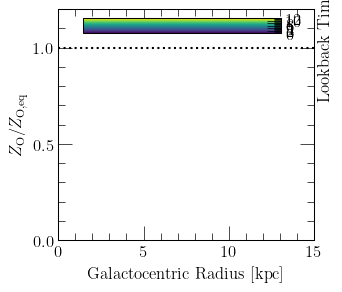

In [5]:
LOOKBACKS = [0, 2, 4, 6, 8, 10, 12]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$Z_\text{O} / Z_\text{O,eq}$")
ax.set_xlim([0, 15])
ax.set_ylim([0, 1.2])
ax.set_yticks([0, 0.5, 1])
ax.axhline(1, c = named_colors()["black"], linestyle = ":")

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
# cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Lookback Time [Gyr]", labelpad = 10)
cbar.set_ticks(LOOKBACKS)

def plot_eqprofile(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, zeq = equilibrium_profile(output, lookback, zone_width = zone_width)
    ratio = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        ratio.append(zone.history["z(o)"][idx] / zeq[i])
    ax.plot(radii[:-1], ratio, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_eqprofile(output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.88)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
plt.show()